- V1 - Start structuring the kernel
- V2 - Keep Structuring the kernel
- V3 - DenseNet121 + zoom train on old validate on new
- V4 - Failed to run due to bug
- *V5 - Succesful output but did not complete all training epochs due to cell freezing 
- V6/V7/V8 - Run as a script to try and solve cell freezing issue 
- *V9 - Clean debugging and unutilized code
- V10
- V11 - Plot metrics


# EfficientNet Keras - Regression

In [1]:
import sys, os
# Add path to import EfficientNets
sys.path.append(os.path.abspath('../input/efficientnets/efficientnets/EfficientNets/keras-efficientnets-master/'))

In [2]:
# To have reproducible results and compare them
import numpy as np 
import tensorflow as tf

# seed = 2019
# np.random.seed(seed)
# tf.set_random_seed(seed)

In [3]:
# Libraries
import json
import math

import scipy as sp
from functools import partial
from collections import Counter
import json

import cv2
from PIL import Image
import numpy as np
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
from keras_efficientnets import EfficientNetB3
from keras import layers
from keras.applications import DenseNet121
from keras.applications.resnet50 import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import Sequence, to_categorical
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.utils import shuffle
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


In [4]:
im_size = 224
batch_size = 32
learning_rate = 5e-5
epochs = 20 
warmup_epochs = 2
warmup_batchsize = 128
warmup_lr = 1e-3
workers = 2

# Loading & Merging

In [5]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')

print(new_train.shape)
print(old_train.shape)

(3662, 2)
(35126, 2)


In [6]:
# Compare columns and codes of old & new datasets
old_train.head()
new_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


Text(0.5, 1.0, 'Old Data')

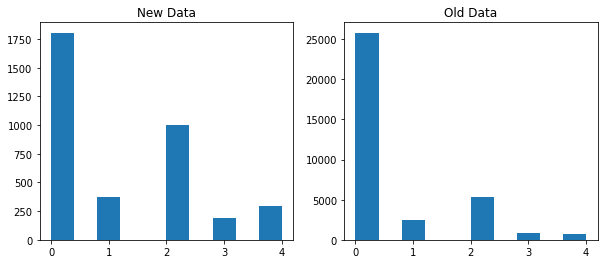

In [7]:
# Visualize Old vs New Data Distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
new_train['diagnosis'].hist(grid=False)
plt.title('New Data')

plt.subplot(1,2,2)
old_train['level'].hist(grid=False)
plt.title('Old Data')

In [8]:
# Assing new column names to old training data
old_train.columns = new_train.columns

# Use old data for training and new for validation
train_df = old_train.copy()
val_df = new_train.copy()

In [9]:
def ClassDistribution(DataFrame):
    class_labels = { 0:  'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative'}
    counts = DataFrame['diagnosis'].value_counts().sort_index()
    total = len(DataFrame)
    result = {}
    for label, count in counts.items():
        result[class_labels[label]] = str(round((count/total)*100, 1))+'%'
    return result 

new_dist = ClassDistribution(new_train)
old_dist = ClassDistribution(old_train)
distributions = pd.DataFrame([new_dist.values(), old_dist.values()], 
                             columns=new_dist.keys(), index=['New Data', 'Old Data'])
distributions


,No DR,Mild,Moderate,Severe,Proliferative
New Data,49.3%,10.1%,27.3%,5.3%,8.1%
Old Data,73.5%,7.0%,15.1%,2.5%,2.0%


In [10]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35126, 2)
(3662, 2)


In [11]:
# Train on old validate on new images
x_train = train_df['id_code']
y_train = train_df['diagnosis']
y_train = to_categorical(y_train, num_classes=5)

x_val = val_df['id_code']
y_val = val_df['diagnosis']
y_val = to_categorical(y_val, num_classes=5)

In [12]:
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(35126, 5)
(3662,)
(3662, 5)


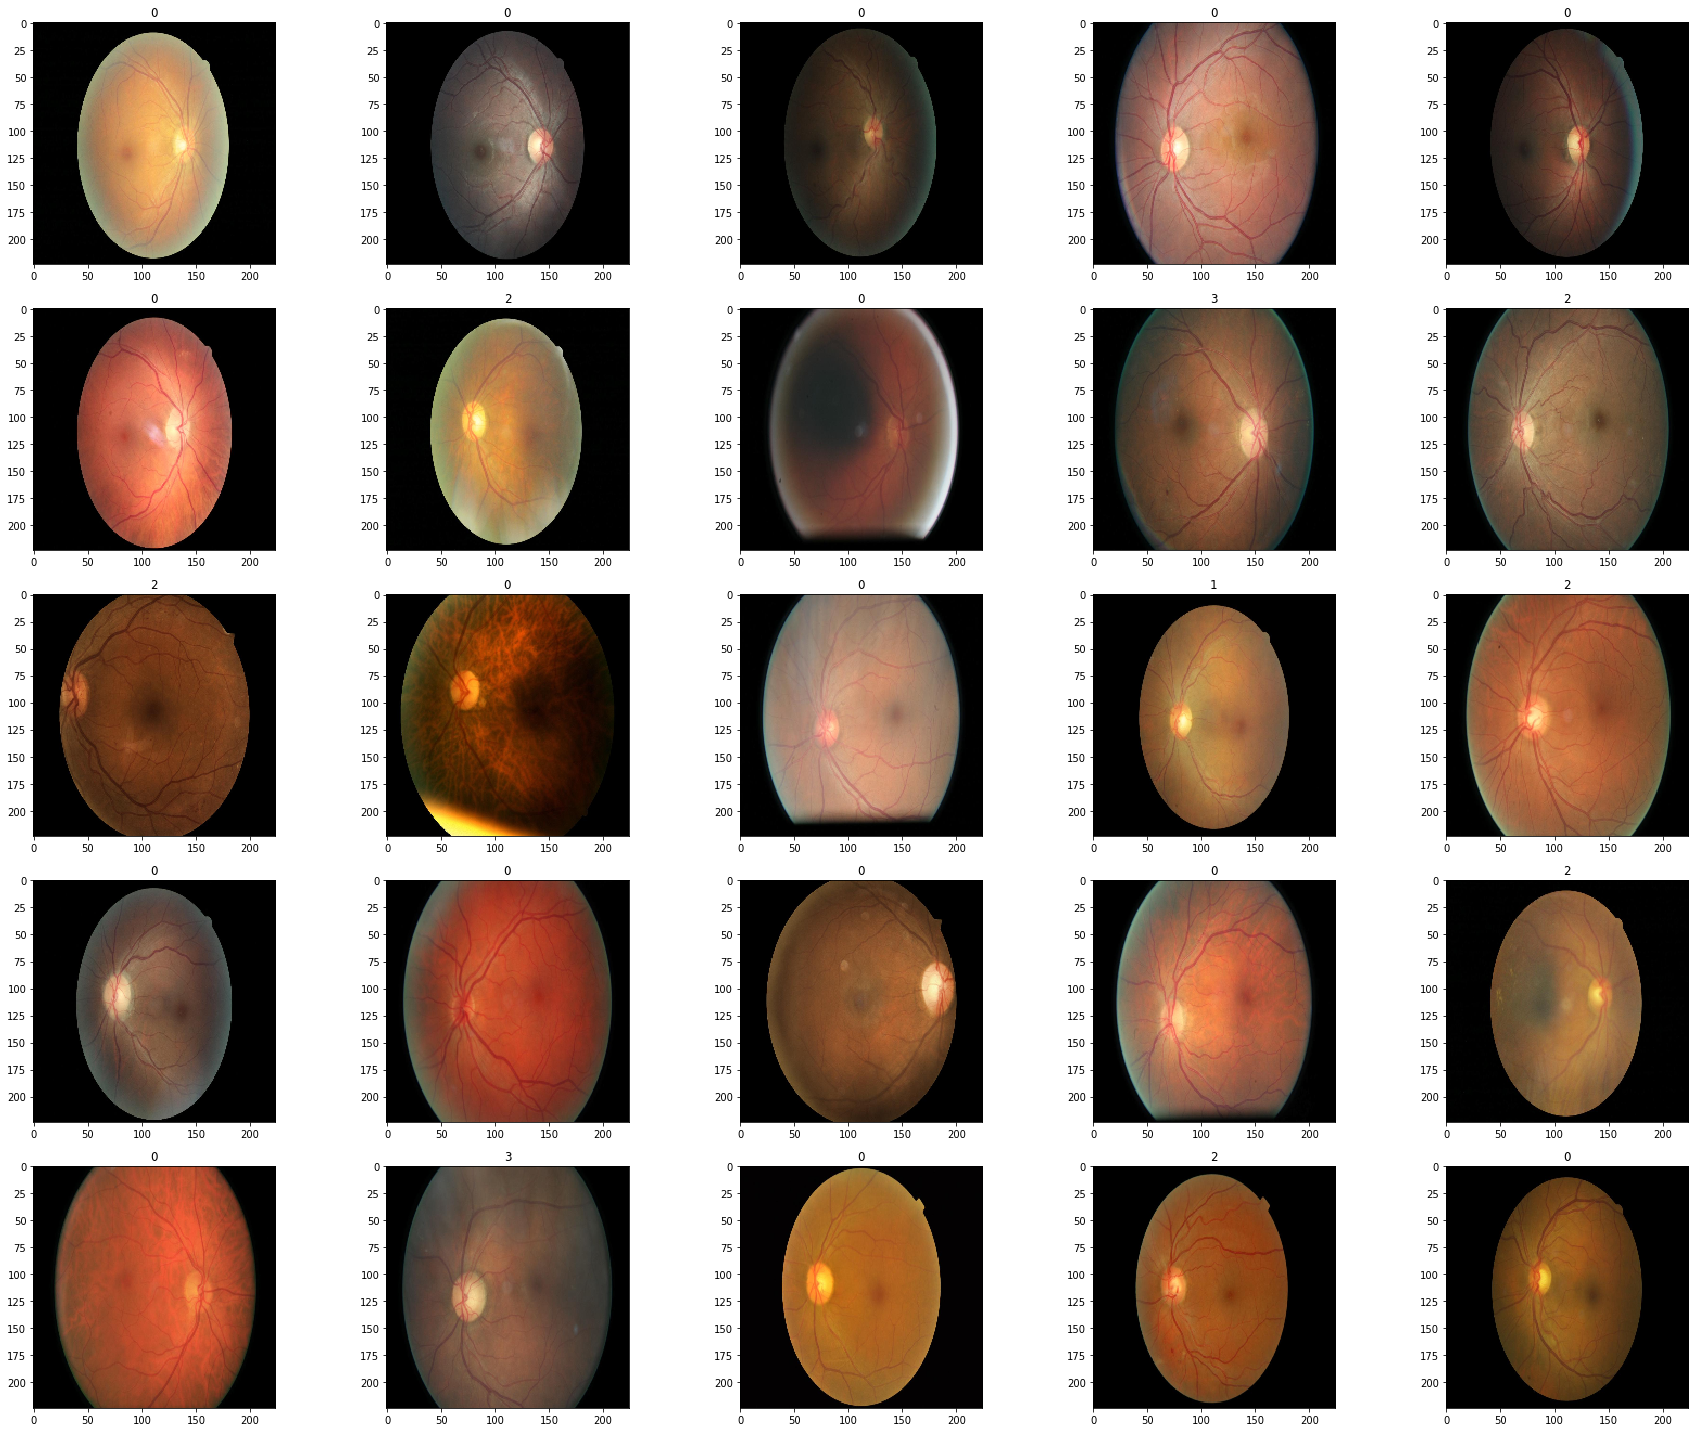

In [13]:
def display_samples(df, columns=5, rows=5):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = f'../input/diabetic-retinopathy-resized/resized_train/resized_train/{df.loc[i,"id_code"]}.jpeg'
        image_label = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (im_size,im_size))
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_label)
        plt.imshow(img)
    
    plt.tight_layout()

# display train images
display_samples(train_df)

# Create Custom Callback for Quadratic Weighted Kappa

In [14]:
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                      steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                      workers=1, use_multiprocessing=True,
                                                      verbose=1)
 
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')

            print(f"val_kappa: {score:.4f}")

            self.history.append(score)
            if score >= max(self.history):
                print("Validation Kappa has improved. Saving model.")
                self.model.save('model.h5')

# Data Generator

In [15]:
# Setup Augmentation
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ]),
    ),
    sometimes( iaa.Affine(scale=(0.9, 1.3))),
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Flipud(0.2)
],random_order=True)

In [16]:
# Create Custom Generator
class MyGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size,
                is_train=False, augment=False):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.augment = augment
        if self.is_train:
            self.on_epoch_end()
                
    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size: (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx+1)* self.batch_size]
        
        if self.is_train:
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)
    
    def on_epoch_end(self):
        if(self.is_train): # Probably redundant but keep it just in case
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
    
    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for image in batch_x:
            # train on old not cropped
            img = cv2.imread(f'../input/diabetic-retinopathy-resized/resized_train/resized_train/{image}.jpeg')
            
            img = cv2.resize(img, (im_size, im_size))
            if self.augment:
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) #/ 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y
    
    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for image in batch_x:
            # Validate on new
            img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image}.png')
            img = cv2.resize(img, (im_size, im_size))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) #/ 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

# Model: EfficientNetB3/ResNet50/DenseNet121

In [17]:
import os
os.listdir('../input/')

['efficientnets',
 'diabetic-retinopathy-resized',
 'aptos2019-blindness-detection',
 'densenet',
 'resnet-50']

In [18]:
# effnet = EfficientNetB3(
#     input_shape=(im_size,im_size,3),
#     weights=sys.path.append(os.path.abspath("""../input/efficientnets/efficientnets/
#     EfficientNets/efficientnet-b3_imagenet_1000_notop.h5,""")),
#     include_top=False
# )

# resnet = ResNet50(
#     input_shape=(im_size,im_size,3),
#     weights=None,
#     include_top=False
# )
# resnet.load_weights('../input/resnet-50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

densenet = DenseNet121(
    input_shape=(im_size,im_size,3),
    weights='../input/densenet/DenseNet-BC-121-32-no-top.h5',
    include_top=False
    )

In [19]:
def build_model():
    model = Sequential()
#     model.add(effnet)
#     model.add(resnet)
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))

    return model

In [20]:

# Initiate Custom Generators
warmup_generator = MyGenerator(x_train, y_train, warmup_batchsize, is_train=True)
train_generator = MyGenerator(x_train, y_train, batch_size, is_train=True, augment=True)
valid_generator = MyGenerator(x_val, y_val, batch_size, is_train=False)


# Initiate Custom Callbacks
kappa_metrics = QWKEvaluation(validation_data=(valid_generator, y_val),
                batch_size=batch_size, interval=1)



early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

# Initiate Model
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 8,092,229
Trainable params: 8,008,581
Non-trainable params: 83,648
_____________________________________________________________

# Warmup Model

In [21]:
# Warmup Model
for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True

model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=warmup_lr),
        metrics=['accuracy']
        )

warmup_history = model.fit_generator(
    warmup_generator,
    steps_per_epoch=np.ceil(float(len(y_train)) / float(warmup_batchsize)),
    epochs=warmup_epochs,
    workers=workers, use_multiprocessing=True,
    verbose=2,
    callbacks=[kappa_metrics]).history


Epoch 1/2
 - 260s - loss: 0.9439 - acc: 0.7209
115/115 [==============================] - 282s 2s/step
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 2/2
 - 246s - loss: 0.8317 - acc: 0.7342
115/115 [==============================] - 270s 2s/step
val_kappa: 0.0000
Validation Kappa has improved. Saving model.


# Train Complete Model

In [22]:
# Unfreeze Layers
for layer in model.layers:
    layer.trainable = True

# Callbacks
callbacks_list = [kappa_metrics, early]


model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=learning_rate),
    metrics=['accuracy'])

finetunning_history = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(x_train))/ float(batch_size)),
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(x_val))/ float(batch_size)),
    callbacks=callbacks_list,
    workers=1, use_multiprocessing=False,
    verbose=2).history


Epoch 1/20
 - 709s - loss: 0.7557 - acc: 0.7499 - val_loss: 0.9628 - val_acc: 0.6537
115/115 [==============================] - 282s 2s/step
val_kappa: 0.8196
Validation Kappa has improved. Saving model.
Epoch 2/20
 - 683s - loss: 0.6799 - acc: 0.7714 - val_loss: 1.0674 - val_acc: 0.6832
115/115 [==============================] - 280s 2s/step
val_kappa: 0.8364
Validation Kappa has improved. Saving model.
Epoch 3/20
 - 668s - loss: 0.6448 - acc: 0.7843 - val_loss: 0.9089 - val_acc: 0.7144
115/115 [==============================] - 271s 2s/step
val_kappa: 0.8474
Validation Kappa has improved. Saving model.
Epoch 4/20
 - 661s - loss: 0.6240 - acc: 0.7913 - val_loss: 0.9632 - val_acc: 0.7540
115/115 [==============================] - 270s 2s/step
val_kappa: 0.8300
Epoch 5/20
 - 651s - loss: 0.6078 - acc: 0.7977 - val_loss: 1.0020 - val_acc: 0.7425
115/115 [==============================] - 271s 2s/step
val_kappa: 0.8618
Validation Kappa has improved. Saving model.
Epoch 6/20
 - 659s - loss

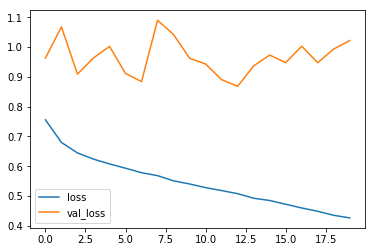

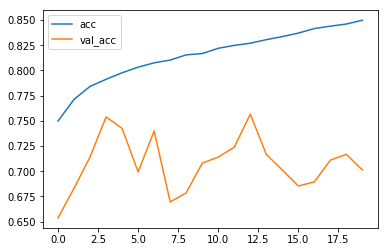

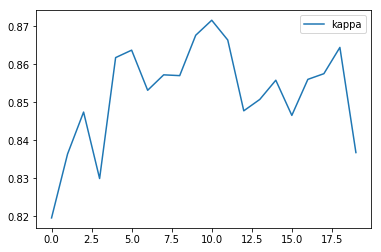

In [23]:
# history = {'loss': warmup_history['loss'] + finetunning_history['loss'],
#            'val_loss': warmup_history['val_loss'] + finetunning_history['val_loss'],
#            'acc': warmup_history['acc'] + finetunning_history['acc'],
#            'val_acc': warmup_history['val_acc'] + finetunning_history['val_acc']}

history = pd.DataFrame(finetunning_history)
history[['loss', 'val_loss']].plot()
history[['acc', 'val_acc']].plot()
if len(history) == len(kappa_metrics.history[2:]):
    history['kappa'] = kappa_metrics.history[2:]
    history[['kappa']].plot()



# fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', fig_size=(20,14))

# ax1.plot(history['loss'], label='Train Loss')
# ax1.plot(history['val_loss'], label='Validation Loss')
# ax1.legend(loc='best')
# ax1.set_title('Loss')

# ax2.plot(history['acc'], label='Train Accuracy')
# ax2.plot(history['val_loss'], label='Validation Loss')
# ax2.legend(loc='best')
# ax2.set_title('Accuracy')

# plt.xlabel('Epochs')
# plt.show()